In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

In [2]:
# read the first 15000 rows of the intervals file
# df = pd.read_csv('data/intervals.csv', nrows=15000)

In [3]:
# we only want the interval data from a single agency
agency = "32000-1"
# read the file in chunks, then append only the data that matches that agency
iter_csv = pd.read_csv('data/intervals.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['uniquename'] == agency] for chunk in iter_csv])

In [7]:
df.describe()

,Unnamed: 0,interval,origindex
count,1.103500e+04,11035.000000,1.103500e+04
mean,2.396286e+06,709.984232,2.443959e+06
std,3.185674e+03,775.509892,1.421359e+06
min,2.390769e+06,60.000000,1.996000e+03
25%,2.393528e+06,176.000000,1.195868e+06
50%,2.396286e+06,717.000000,2.442274e+06
75%,2.399044e+06,839.500000,3.690540e+06
max,2.401803e+06,15798.000000,4.873760e+06


In [8]:
df.head()

,Unnamed: 0,interval,origindex,timestamp,uniquename
2390769,2390769,939.0,1996.0,2018-09-13 00:51:27,32000-1
2390770,2390770,150.0,2094.0,2018-09-13 00:53:57,32000-1
2390771,2390771,702.0,2493.0,2018-09-13 01:05:39,32000-1
2390772,2390772,126.0,2574.0,2018-09-13 01:07:45,32000-1
2390773,2390773,811.0,3056.0,2018-09-13 01:21:16,32000-1


In [32]:
# the series of interest
series_of_interest = df["interval"]
# # of bins
bins_to_use = 100

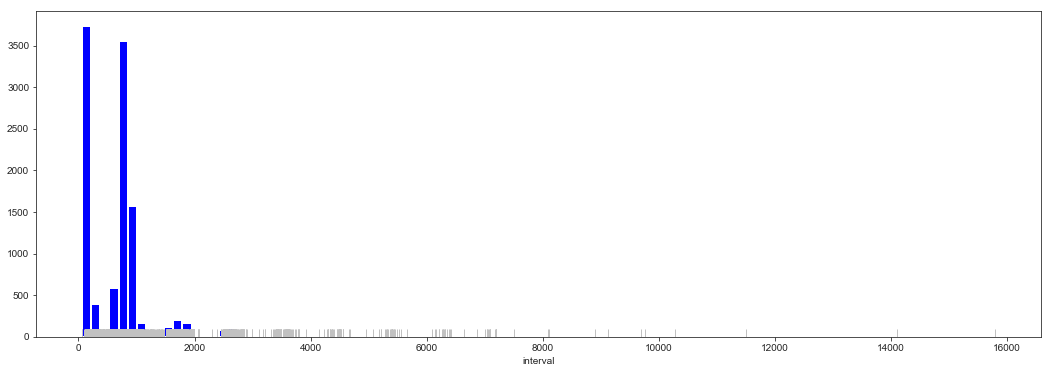

In [33]:
# graph the distribution of intervals
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
rugkws={"height": .025, "color": "999999"}
histkws={"linewidth": 2, "alpha": 1, "color": "b"}
p = sns.distplot(series_of_interest, bins=bins_to_use, rug=True, rug_kws=rugkws, hist_kws=histkws, kde=False).patches

In [34]:
# get the heights of the bins
heights = [item.get_height() for item in p]
# the highest
print(max(heights))

3735.0


In [35]:
# and here is the bucket index of the max of that list
most_populous_bucket = np.argmax(heights)
print(most_populous_bucket)

0


In [36]:
# get the stats using the same bucketing parameters
bin_maxes, bin_edges, binnumber = stats.binned_statistic(series_of_interest, series_of_interest, statistic=max, bins=bins_to_use)

/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [37]:
# and here is the max of the binned values from the bin with the most members
# remember, the 'statistic' called for was 'max' (not mean)
bin_maxes[most_populous_bucket]

217.0

In [38]:
# and here is the right bin-edge from that same bin
bin_edges[most_populous_bucket+1]

217.38